## Introduction

An example of node classification on a homogeneous graph using the `Node2Vec` representation learning algorithm. The example uses components from the `stellargraph`, `Gensim`, and `scikit-learn` libraries.

**Note:** For clarity of exposition, this notebook forgoes the use of standard machine learning practices such as `Node2Vec` parameter tuning, node feature standarization, data splitting that handles class imbalance, classifier selection, and classifier tuning to maximize predictive accuracy. We leave such improvements to the reader.

<a name="refs"></a>
### References

[1] Node2Vec: Scalable Feature Learning for Networks. A. Grover, J. Leskovec. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2016. ([link](https://snap.stanford.edu/node2vec/))

[2] Distributed representations of words and phrases and their compositionality. T. Mikolov, I. Sutskever, K. Chen, G. S. Corrado, and J. Dean.  In Advances in Neural Information Processing Systems (NIPS), pp. 3111-3119, 2013. ([link](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf))

[3] Gensim: Topic modelling for humans. ([link](https://radimrehurek.com/gensim/))

[4] scikit-learn: Machine Learning in Python ([link](http://scikit-learn.org/stable/))

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install node2vec

In [0]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

import os
import networkx as nx
import numpy as np
import pandas as pd

%matplotlib inline

### Dataset


The dataset is the citation network Cora.

It can be downloaded by clicking [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz)

The following is the description of the dataset from the publisher,

> The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. The README file in the dataset provides more details. 

For this demo, we ignore the word vectors associated with each paper. We are only interested in the network structure and the **subject** attribute of each paper.

Download and unzip the cora.tgz file to a location on your computer. 

We assume that the dataset is stored in the directory

`~/data/cora/`

where the files `cora.cites` and `cora.content` can be located.

We are going to load the data into a networkx object.

In [0]:
import pandas as pd
graph_df=pd.read_csv('drive/My Drive/movies_50000_gd_top.csv')

In [0]:
# gd = pd.read_csv('drive/My Drive/movies_csv_v5.csv')
# gd_group = gd[[side_a,side_b,weightCol]].groupby([side_a,side_b]).count()
# z = gd_group.sort_values(by='time',ascending=False)[:10000]
# sum(z['time'])
# gd_top = gd.join(z.reset_index()[[side_a]].drop_duplicates().set_index(side_a),on=side_a,how='inner') \
#            .join(z.reset_index()[[side_b]].drop_duplicates().set_index(side_b),on=side_b,how='inner') 
# gd_top = gd.join(z.drop(columns=['time']),on=[side_a,side_b],how='inner')
# gd_top
# gd_top.to_csv('drive/My Drive/movies_50000_gd_top.csv')
# plt.hist(gd_top[[side_a,side_b,weightCol]].groupby([side_a,side_b]).count().sort_values(by='time',ascending=False)['time'].astype(float))
# gd_top

In [0]:
join_field_data='side_a_id'
join_field_label='0'

# # label_df=pd.read_csv('drive/My Drive/actors_labels_ready.csv')
# graph_df=graph_df.join(label_df.rename(columns={join_field_label:join_field_data}).set_index(join_field_data),on=join_field_data,how='left')

In [28]:
graph_df.head()

Unnamed: 0     id  side_a_id  side_b_id          time
0           0    862         31      12898  3.815011e+09
1      922358    863         31      12898  3.941242e+09
2     2586446    920         31      12898  4.149725e+09
3     3466576  10193         31      12898  4.276646e+09
4     3625455  15302         31      12898  4.188259e+09

In [0]:
 label_field='Animation'

In [0]:
from sklearn.model_selection import train_test_split

In [31]:
1# graph_df_node_label = graph_df[[join_field_data,label_field]].drop_duplicates()
# train_data,test_data=train_test_split(graph_df_node_label,test_size=0.25,stratify=graph_df_node_label[label_field])

1

In [0]:
# train_data.shape,test_data.shape

In [0]:
side_a=join_field_data
side_b='side_b_id'
join_field=side_a

In [0]:
weightCol='time'

## Divide Graph ton Time slices

In [0]:
all_times = sorted(list(set(graph_df[weightCol])))

In [0]:
slices_count = 5
amount_per_slice = round(len(all_times)/slices_count)

In [16]:
values = list(range(0,len(all_times),amount_per_slice))
thresholds = []
should_break = False
for i,index in enumerate(values):
  print(i,index)
  current_amount_per_slice = amount_per_slice
  if(i == len(values)-2):
    current_amount_per_slice = current_amount_per_slice * 2
    should_break = True
  print(len(all_times[index:index+current_amount_per_slice]))
  cur_df = all_times[index:index+current_amount_per_slice]
  min_time = min(cur_df)
  max_time = max(cur_df)
  thresholds.append([min_time,max_time])
  if(should_break):
    break
  print(' ')

0 0
1272
 
1 1272
1272
 
2 2544
1272
 
3 3816
1272
 
4 5088
1274


In [17]:
thresholds

[[664780800.0, 2273548800.0],
 [2273635200.0, 3037584000.0],
 [3038016000.0, 3755395200.0],
 [3755568000.0, 4188518400.0],
 [4188604800.0, 4513814400.0]]

In [0]:
def groupby_time(df):
  return df.groupby([side_a,side_b]).count().reset_index()

In [0]:
def create_graph(df):
  return nx.from_pandas_edgelist(df,source=side_a,target=side_b,edge_attr=[weightCol])  

In [0]:
all_nodes = list(create_graph(graph_df).nodes())

In [21]:
len(all_nodes),len(  set(graph_df[side_a]).union(set(graph_df[side_b]))  )

(4164, 4164)

In [0]:
# divide graph
dfs= []
for threshold in thresholds:
  current_graph_slice = graph_df[ (graph_df[weightCol] >= threshold[0]) & (graph_df[weightCol] <= threshold[1])]
  grouped_df = groupby_time(current_graph_slice)
  g = create_graph(grouped_df)
  # g.add_nodes_from(all_nodes)

  dfs.append({
      'df':grouped_df,
      'g':g
  })

In [23]:
len(dfs) 

5

In [24]:
dfs[0]['df'].head()

side_a_id  side_b_id  Unnamed: 0  id  time
0         40       7664           1   1     1
1         40      14364           4   4     4
2        854       4119           1   1     1
3        854       4303           5   5     5
4        854       8516           2   2     2

## Create Time and Group Graphs

### The Node2Vec algorithm

The Node2Vec algorithm introduced in [[1]](#refs) is a 2-step representation learning algorithm. The two steps are,

1. Use 2nd order random walks to generate sentences from a graph. A sentence is a list of node ids. The set of all sentences makes a corpus.

2. The corpus is then used to learn an embedding vector for each node in the graph. Each node id is considered a unique word/token in a dictionary that has size equal to the number of nodes in the graph. The Word2Vec algorithm [[2]](#refs), is used for calculating the embedding vectors.


## Corpus generation using random walks

The stellargraph library provides an implementation for 2nd order random walks as required by Node2Vec. The random walks have fixed maximum length and are controlled by two parameters `p` and `q`. See [[1]](#refs) for a detailed description of these parameters. 

We are going to start 10 random walks from each node in the graph with a length up to 100. We set parameter `p` to 0.5 and `q` to 2.0.

In [0]:
import networkx as nx
from node2vec import Node2Vec

# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
def create_embed_model(g):
  embed = Node2Vec(g, dimensions=32, walk_length=30, num_walks=200, workers=20,p=4,q=0.25)
  model = embed.fit(window=10, min_count=1, batch_words=4)
  return embed, model 


## Create embed per slice

In [0]:
from tqdm import tqdm

for data in tqdm(dfs):
  g = data['g']
  embed, model = create_embed_model(g)
  data['embed']=embed
  data['model']=model

Computing transition probabilities: 100%|██████████| 1310/1310 [00:00<00:00, 3112.09it/s]/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
100%|██████████| 5/5 [1:17:43<00:00, 950.07s/it]


In [0]:
import pickle

with open('drive/My Drive/models_lstm_embed.pkl','wb') as f:
  pickle.dump(dfs,f)

In [0]:
with open('drive/My Drive/models_lstm_embed.pkl','rb') as f:
  vs= pickle.load(f)

In [0]:
vs[0]['model'].wv.vectors

array([[ 1.9554497e+00, -3.5315688e+00, -1.1053847e+00, ...,
         9.2402446e-01, -5.5186123e-01,  5.3412700e-01],
       [ 3.8121467e+00,  1.4895926e+00, -2.6757138e+00, ...,
         2.7012247e-01,  3.4759313e-01,  2.3535850e+00],
       [-5.2477117e+00,  2.7914522e+00,  3.5527700e-01, ...,
         5.7695401e-01,  4.9942186e-01, -3.7108812e+00],
       ...,
       [ 1.7469959e+00,  1.1185621e+00, -8.5486408e-04, ...,
         9.9001426e-01,  2.7247411e-01,  7.7983636e-01],
       [ 2.2455699e+00,  1.0882425e+00,  3.9331833e-01, ...,
         6.3718551e-01,  4.3141192e-01,  1.1543878e+00],
       [-8.6865258e-01, -1.3165087e+00,  1.8646556e-01, ...,
         8.2781557e-03,  1.1635327e+00, -3.4027536e+00]], dtype=float32)

## Vis

In [0]:
from sklearn.manifold import TSNE

  0%|          | 0/5 [00:00<?, ?it/s]

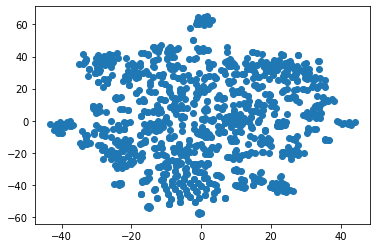

 20%|██        | 1/5 [00:25<01:43, 25.93s/it]

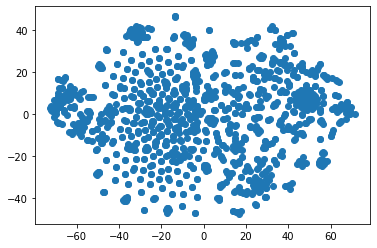

 40%|████      | 2/5 [00:53<01:19, 26.52s/it]

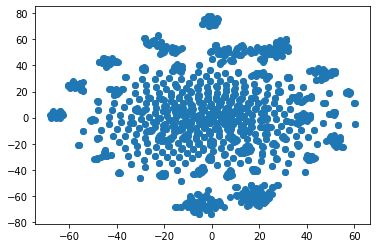

 60%|██████    | 3/5 [01:18<00:51, 25.86s/it]

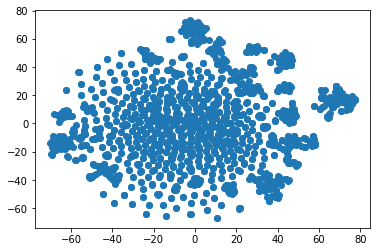

 80%|████████  | 4/5 [01:46<00:26, 26.66s/it]

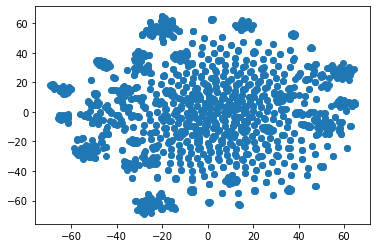

100%|██████████| 5/5 [02:14<00:00, 26.95s/it]


In [0]:
for v in tqdm(vs):
  mat_t = TSNE().fit_transform(v['model'].wv.vectors)
  plt.scatter(x=mat_t[:,0],y=mat_t[:,1])
  plt.show()
  

## Create Full Data

In [0]:
df_full_vectors = None
for i,v in enumerate(tqdm(vs)):
  df = pd.DataFrame(v['model'].wv.vectors)
  df[join_field]=v['model'].wv.index2word
  df_full_vectors = df if df_full_vectors is None else df_full_vectors.join(df.set_index(join_field),on=join_field,how='outer',rsuffix='_slice{}'.format(i))

100%|██████████| 5/5 [00:00<00:00, 89.90it/s]


In [0]:
df_full_vectors = df_full_vectors.fillna(0)

In [0]:
len(df_full_vectors)

4164

In [0]:
# df_full_vectors.to_csv('drive/My Drive/df_full_vectors_lstm_vectors.csv')

In [0]:
df_full_vectors = pd.read_csv('drive/My Drive/df_full_vectors_lstm_vectors.csv')

## Add Labels

In [60]:

labels_pd = pd.read_csv('drive/My Drive/actors_labels_ready.csv').dropna()
labels_pd = labels_pd.rename(columns={'0':join_field})
all_labels=labels_pd.drop(columns=[join_field]).columns
all_labels

Index(['Action', 'Science Fiction', 'TV Movie', 'Horror', 'Drama', 'History',
       'Adventure', 'Crime', 'Foreign', 'Romance', 'Comedy', 'Music', 'Family',
       'Mystery', 'War', 'Documentary', 'Thriller', 'Western', 'Animation',
       'Fantasy'],
      dtype='object')

In [61]:
labels_pd

side_a_id  Action  Science Fiction  ...  Western  Animation  Fantasy
0               1       1                1  ...        0          1        1
1               2       1                1  ...        0          1        1
2               3       1                1  ...        1          0        1
3               4       1                1  ...        0          0        1
4               5       1                1  ...        0          0        1
...           ...     ...              ...  ...      ...        ...      ...
205740    1048570       0                0  ...        0          0        0
205741    1048571       1                0  ...        0          0        0
205742    1048572       0                0  ...        0          0        0
205743    1048574       1                1  ...        0          1        1
205744    1048575       0                0  ...        0          0        1

[205745 rows x 21 columns]

In [0]:
def create_labeled_df(df,labels_pd,join_field):
  # df = pd.DataFrame(model.wv.vectors)
  # df[join_field]=model.wv.index2word
  df[join_field] = df[join_field].astype(str)
  labels_pd[join_field] = labels_pd[join_field].astype(str)
  df_labeled = df.join(labels_pd.set_index(join_field),on=join_field,how='inner')
  return df_labeled

In [0]:
df_full = create_labeled_df(df_full_vectors,labels_pd,join_field)

In [0]:
from tqdm import tqdm
def get_x(df_full,all_labels,join_field,dim=32,slices =5):
  df_full_x = df_full.drop(columns=['Unnamed: 0',join_field]+list(all_labels))
  
  dfs_vecs = []
  for i in range(0,dim*slices,dim):
    dfs_vecs.append(df_full_x[list(df_full_x.columns)[i:i+dim]])
  
  mats = []
  for i,row in tqdm(df_full_x.iterrows(),total=len(dfs_vecs)):
    mat = np.vstack([ d.values[i] for d in dfs_vecs])
    mats.append(mat)
  return np.stack(mats,axis=0)

(4164, 5, 32)

(5, 32)

In [0]:
# from __future__ import print_function
# import numpy as np

# from keras.preprocessing import sequence
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
# from keras.datasets import imdb


# max_features = 20000
# # cut texts after this number of words
# # (among top max_features most common words)
# maxlen = 100
# batch_size = 32

# print('Loading data...')
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
# print(len(x_train), 'train sequences')
# print(len(x_test), 'test sequences')

# print('Pad sequences (samples x time)')
# x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
# x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
# print('x_train shape:', x_train.shape)
# print('x_test shape:', x_test.shape)
# y_train = np.array(y_train)
# y_test = np.array(y_test)

# model = Sequential()
# model.add(Embedding(max_features, 128, input_length=maxlen))
# model.add(Bidirectional(LSTM(64)))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

# # try using different optimizers and different optimizer configs
# model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

# print('Train...')
# model.fit(x_train[:100], y_train[:100],
#           batch_size=batch_size,
#           epochs=1,
#           validation_data=[x_test, y_test])

In [0]:

from keras.layers import Dense,Dropout,LSTM,Flatten
from keras.models import Sequential
from tqdm import tqdm
from sklearn.metrics import classification_report,accuracy_score,recall_score,precision_score,roc_auc_score
from sklearn.utils import class_weight
import numpy as np
import keras

def train_models(df_labeled,labels_pd,all_labels,join_field,labels_to_take):
  # X will hold the 128-dimensional input features
  X = get_x(df_labeled,all_labels,join_field)#df_labeled.drop(columns=[join_field]+list(labels_pd.drop(columns=[join_field]).columns)).values
  # y holds the corresponding target values
  y = df_labeled[list(labels_pd.drop(columns=[join_field]).columns)].values
  print(X.shape,y.shape)

  
  all_models=[]
  for i,label in enumerate(tqdm(all_labels)):
    if(not (label in labels_to_take)):
      continue
    y_current = y[:,i].ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y_current, test_size=0.2,stratify=y_current)
    print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

    print(label,i)
    y_train_current=y_train
    y_test_current=y_test
    
    class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train_current),y_train_current)
    class_weights = dict(enumerate(class_weights))
    
    input_shape = (X_train.shape[1],X_train.shape[2])
    print('input_shape: {}'.format(input_shape))

    t_model = Sequential()
    t_model.add(LSTM(output_dim=32, init='uniform', inner_init='uniform',
               forget_bias_init='one', return_sequences=True, activation='tanh',
               inner_activation='sigmoid', input_shape=input_shape))
    t_model.add(Dropout(0.4))
    t_model.add(Flatten())
    t_model.add(Dense(16, activation="relu"))
    t_model.add(Dropout(0.4))
    t_model.add(Dense(1, activation="sigmoid"))
    t_model.compile(
        loss="binary_crossentropy",
        optimizer='adam',
        metrics=['acc'])
    early = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=2)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.000001, verbose=2)

    t_model.fit(X_train,y_train_current,verbose=2,validation_split=0.1,epochs=100,class_weight=class_weights,callbacks=[early,reduce_lr])
    
    y_pred = t_model.predict_classes(X_test)
    y_pred_proba = t_model.predict(X_test)
      
    accuracy=accuracy_score(y_test_current, y_pred)
  
    classification_report_pd = pd.DataFrame(classification_report(y_test_current, y_pred,output_dict=True))
    precision_0 = classification_report_pd.iloc[0][0]
    precision_1 = classification_report_pd.iloc[0][1]
    recall_0 = classification_report_pd.iloc[1][0]
    recall_1 = classification_report_pd.iloc[1][1]
    mean_score_0 = np.mean([precision_0,recall_0])
    mean_score_1 = np.mean([precision_1,recall_1])
    mean_score = np.mean([precision_0,precision_1,recall_0,recall_1])
    roc_auc=roc_auc_score(y_test_current, y_pred_proba)
    
    all_models.append({
        'label':label,
        'i':i,
        'model':t_model,
        'accuracy':accuracy,
        'mean_score_0':mean_score_0,
        'mean_score_1':mean_score_1,
        'precision_0':precision_0,
        'precision_1':precision_1,
        'recall_0':recall_0,
        'recall_1':recall_1,
        'mean_score':mean_score,
        'roc_auc':roc_auc
    })


  return all_models

In [125]:
%%time
labels_to_take=['Animation']
all_models = train_models(df_full,labels_pd,all_labels,join_field,labels_to_take)

4164it [00:00, 10358.02it/s]
  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, activation="tanh", input_shape=(5, 32), unit_forget_bias=True, units=32, kernel_initializer="uniform", recurrent_initializer="uniform", recurrent_activation="sigmoid")`


(4164, 5, 32) (4164, 20)
Array shapes:
 X_train = (3331, 5, 32)
 y_train = (3331,)
 X_test = (833, 5, 32)
 y_test = (833,)
Animation 18
input_shape: (5, 32)
Train on 2997 samples, validate on 334 samples
Epoch 1/100
 - 4s - loss: 0.6739 - acc: 0.6316 - val_loss: 0.6438 - val_acc: 0.7275
Epoch 2/100
 - 1s - loss: 0.6203 - acc: 0.6583 - val_loss: 0.5650 - val_acc: 0.7216
Epoch 3/100
 - 1s - loss: 0.5594 - acc: 0.6920 - val_loss: 0.5256 - val_acc: 0.7665
Epoch 4/100
 - 1s - loss: 0.5113 - acc: 0.7484 - val_loss: 0.4950 - val_acc: 0.7335
Epoch 5/100
 - 1s - loss: 0.4627 - acc: 0.7738 - val_loss: 0.4826 - val_acc: 0.7695
Epoch 6/100
 - 1s - loss: 0.4380 - acc: 0.7851 - val_loss: 0.5033 - val_acc: 0.7725
Epoch 7/100
 - 1s - loss: 0.4104 - acc: 0.8008 - val_loss: 0.4997 - val_acc: 0.8174

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 8/100
 - 1s - loss: 0.3751 - acc: 0.8325 - val_loss: 0.4964 - val_acc: 0.8084
Epoch 9/100
 - 1s - loss: 0.3652 - acc: 0.

100%|██████████| 20/20 [00:16<00:00,  1.23it/s]

CPU times: user 19.8 s, sys: 605 ms, total: 20.4 s
Wall time: 16.7 s


In [127]:
pd.DataFrame(all_models).sort_values(by='accuracy',ascending=False)

label   i  ... mean_score   roc_auc
0  Animation  18  ...   0.768215  0.858073

[1 rows x 12 columns]

label   i  ... mean_score   roc_auc
0  Animation  18  ...   0.757977  0.869599

[1 rows x 12 columns]

In [0]:
# all_labels_unique = set([x.split('_')[0] for x in labels_pd.drop(columns=[join_field]).columns])

In [0]:
# all_labels_unique = set([x.split('_')[0] for x in labels_pd.drop(columns=[join_field]).columns])
# gt_check = []
# for i,row in tqdm(labels_pd.iterrows(),total=len(labels_pd)):
#   amount = 0
#   wrong_label = []
#   for un_label in all_labels_unique:
#     if(row[un_label+'_a']!=row[un_label+'_b']):
#       amount = amount+1
#       wrong_label.append(un_label)
#   gt_check.append({
#       join_field:row[join_field],
#       'amount':amount,
#       'wrong_label':wrong_label
#   })


In [0]:
# gt_check_pd = pd.DataFrame(gt_check)

In [0]:
# gt_check_pd.groupby(['amount']).count()

## Draw Graph

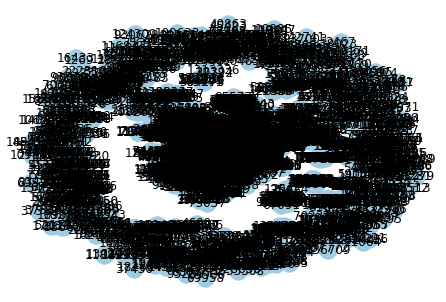

In [0]:
# import matplotlib.pyplot as plt
# import networkx as nx

# pos=nx.spring_layout(graph_count_weight)   #G is my graph

# nx.draw(graph_count_weight,pos,node_color='#A0CBE2',edge_color='#BB0000',width=2,edge_cmap=plt.cm.Blues,with_labels=True)
# #plt.show()
# plt.savefig("graph.png", dpi=100, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format=None,transparent=False, bbox_inches=None, pad_inches=0.1)

In [0]:
!pip install umap-learn requests datashader


     |████████████████████████████████| 15.5MB 3.7MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
     |████████████████████████████████| 81kB 13.5MB/s 
     |████████████████████████████████| 1.6MB 47.8MB/s 
  Created wheel for datashape: filename=datashape-0.5.2-cp36-none-any.whl size=59428 sha256=ef4677c86c0695c6fae344dd8c5ae1ee4c725a362e6fd4b3c751fd51f1ed0eca
  Stored in directory: /root/.cache/pip/wheels/8d/06/05/c1cba3d57bdcfd3960e3f60a9fdc97e4baef2ef09af0ad1ef8
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4039 sha256=6a28ca0891ea8e830a5fac83de7a184ff6458a804d7bfd0565ff5b66ae3418d1
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built datashape locket


In [0]:
!pip install cudf

     |████████████████████████████████| 17.2MB 4.0MB/s 
     |████████████████████████████████| 9.1MB 38.7MB/s 
     |████████████████████████████████| 12.4MB 32.0MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


### time vis

In [0]:
from sklearn.manifold import TSNE

In [0]:
import matplotlib.pyplot as plt
def show_embed(df_label,join_field,all_labels):
  x = df_label.drop(columns=[join_field]+list(all_labels))
  print('x shape: {}'.format(x.shape))
  t = TSNE()
  mat = t.fit_transform(x)
  for label in all_labels:
     print(label)
     y_color = df_label[label] 
     plt.scatter(x=mat[:,0],y=mat[:,1],c=y_color)
     plt.show()
  return mat

x shape: (4164, 64)
Action


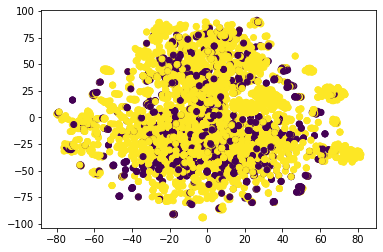

Science Fiction


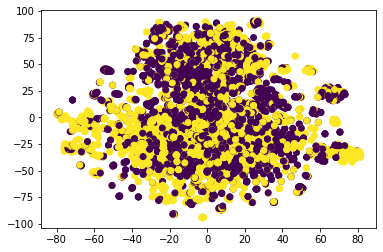

TV Movie


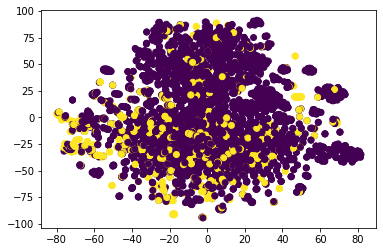

Horror


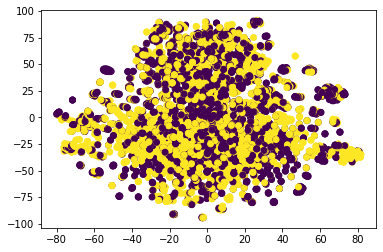

Drama


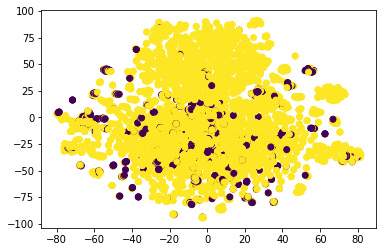

History


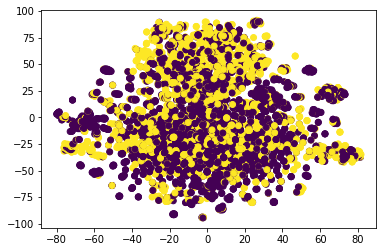

Adventure


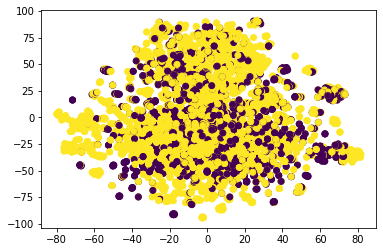

Crime


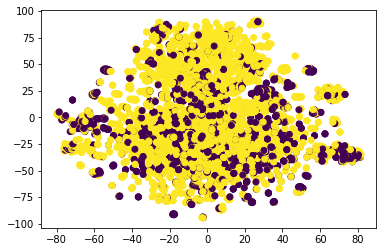

Foreign


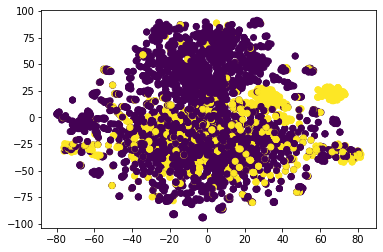

Romance


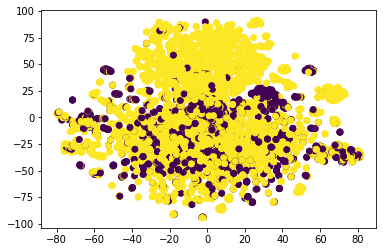

Comedy


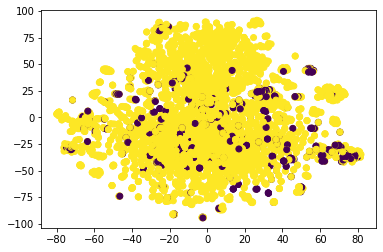

Music


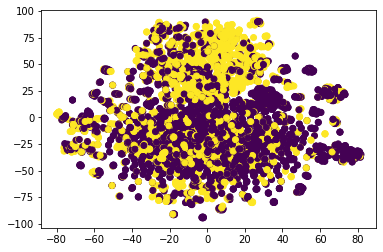

Family


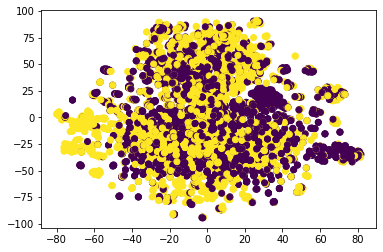

Mystery


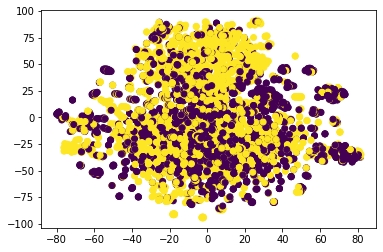

War


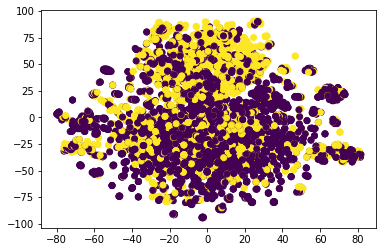

Documentary


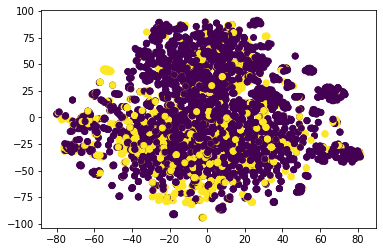

Thriller


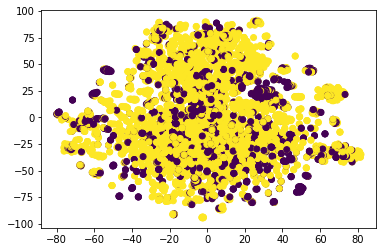

Western


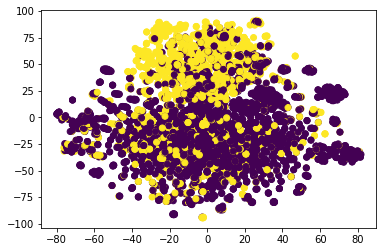

Animation


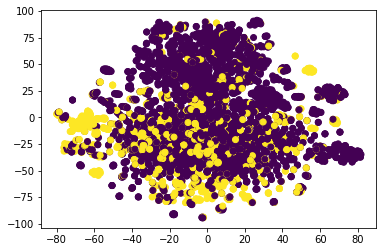

Fantasy


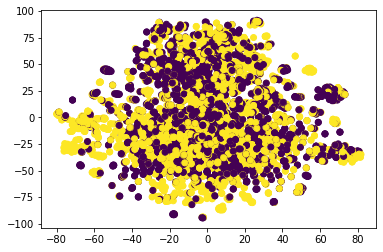

CPU times: user 43.1 s, sys: 2.12 s, total: 45.2 s
Wall time: 43 s


In [0]:
%%time
mat_time = show_embed(time_df_labeled,join_field,all_labels)

### count vis

x shape: (4164, 64)
Action


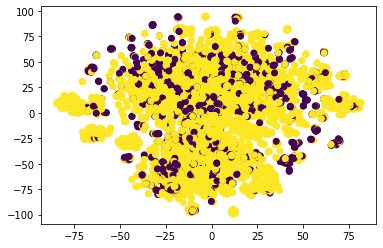

Science Fiction


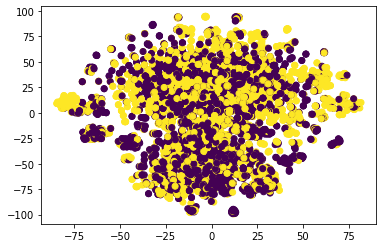

TV Movie


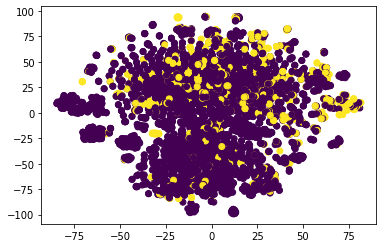

Horror


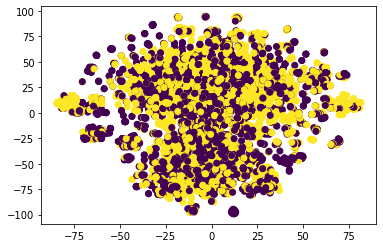

Drama


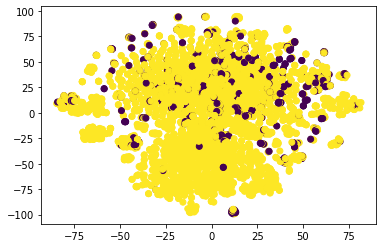

History


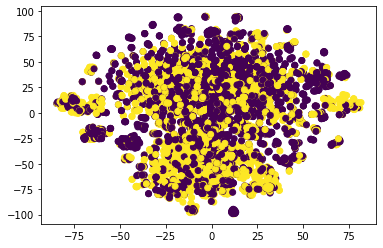

Adventure


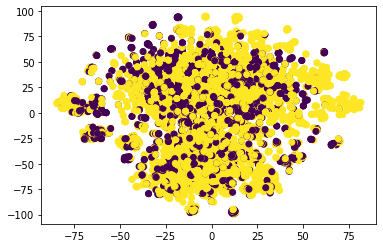

Crime


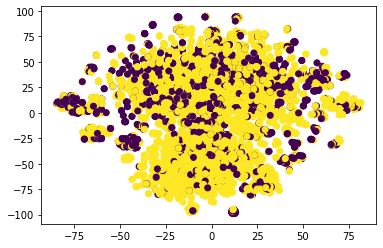

Foreign


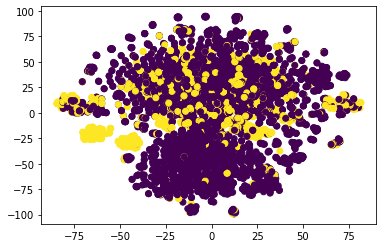

Romance


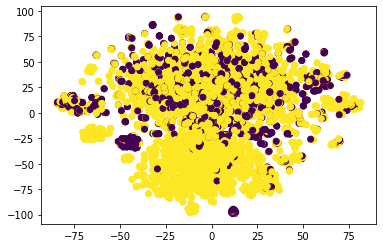

Comedy


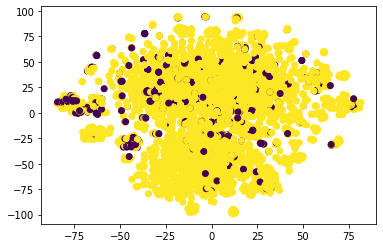

Music


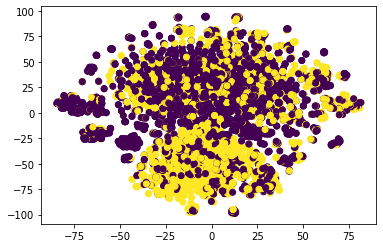

Family


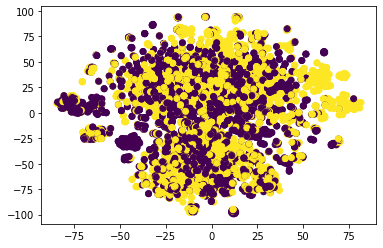

Mystery


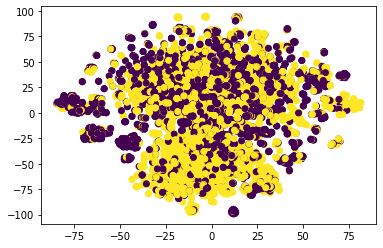

War


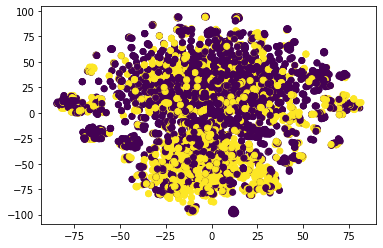

Documentary


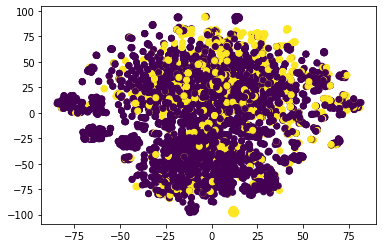

Thriller


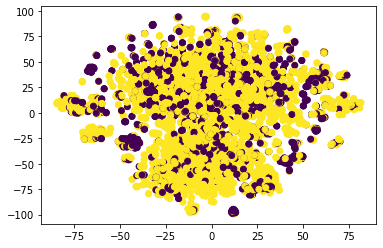

Western


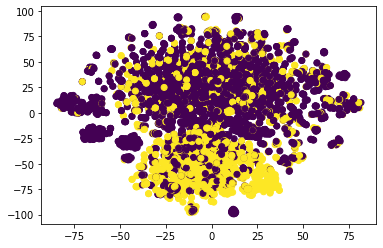

Animation


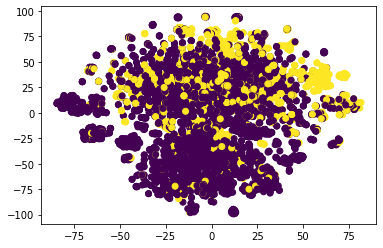

Fantasy


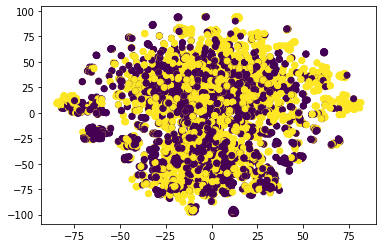

CPU times: user 45.4 s, sys: 2.2 s, total: 47.6 s
Wall time: 45.5 s


In [0]:
%%time
mat_count = show_embed(count_df_labeled,join_field,all_labels)

## Create Gml

In [0]:
graph_df

Unnamed: 0      id  side_a_id  side_b_id          time
0               0     862         31      12898  3.815011e+09
1          922358     863         31      12898  3.941242e+09
2         2586446     920         31      12898  4.149725e+09
3         3466576   10193         31      12898  4.276646e+09
4         3625455   15302         31      12898  4.188259e+09
...           ...     ...        ...        ...           ...
50422     6894234  134632      81378     105799  4.349741e+09
50423     6894035  227257      75037     191855  4.320019e+09
50424     6894041  290727      75037     191855  4.412554e+09
50425     6894090  260234      75037     191855  4.395706e+09
50426     6894237  134632      75037     191855  4.349741e+09

[50427 rows x 5 columns]

In [0]:
from tqdm import tqdm

def create_gml(df,source,target,weight):
  init_str = """
  Creator "None"
  graph
  [
  """
  nodes = list(set(list(df[source])+list(df[target])))
  for node in tqdm(nodes):
    init_str = """
    {init}
      node
      [
        id {id}
        label "{id}"
      ]
    """.format(init=init_str,id=node)
  for i,row in tqdm(df.iterrows(),total=len(df)):
    init_str = """
    {init}
      edge
      [
        source {source}
        target {target}
        value {value}
      ]
    """.format(init=init_str,source=row[source],target=row[target],value=row[weight])
  init_str = """
  {init}
  ]
  """.format(init=init_str)
  return init_str

In [0]:
# init_str = create_gml(graph_df,source=side_a,target=side_b,weight=weightCol)

In [0]:
# with open('g.gml','w') as f:
#   f.write(init_str)

In [0]:
!pip install ForceAtlas2

  Created wheel for ForceAtlas2: filename=ForceAtlas2-1.0-cp36-cp36m-linux_x86_64.whl size=155008 sha256=25f1fac9745079e162854bdf73cefe1b43ea032ebb52f503d2fef9da7a01c542
  Stored in directory: /root/.cache/pip/wheels/fa/5c/65/96aba3f9d5acd70d7b27a382c2f92c2f5fc9171ff66a985db9
Successfully built ForceAtlas2


In [0]:
import matplotlib.pyplot as plt 
import networkx 
import random 
import forceatlas2 
pos = { i : (random.random(), random.random()) for i in graph_count_weight.nodes()} # Optionally specify positions as a dictionary 

In [0]:
%%time
l = forceatlas2.forceatlas2_networkx_layout(graph_count_weight, pos, niter=1000) # Optionally specify iteration count 


CPU times: user 1min 26s, sys: 22.7 ms, total: 1min 26s
Wall time: 1min 26s


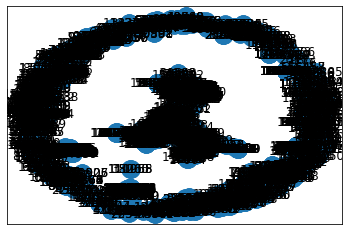

In [0]:
%%time
networkx.draw_networkx(graph_count_weight, l) 
plt.show()

In [0]:
from keras.models import  Model
from keras.layers import  Input
from keras import backend as K

In [0]:
def calculating_class_weights(y_true):
    from sklearn.utils.class_weight import compute_class_weight
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])
    return weights

def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss

def train_models_multi(df_labeled,labels_pd,all_labels,join_field):
  # X will hold the 128-dimensional input features
  X = df_labeled.drop(columns=[join_field]+list(labels_pd.drop(columns=[join_field]).columns)).values
  # y holds the corresponding target values
  y = df_labeled[list(labels_pd.drop(columns=[join_field]).columns)].values
  print(X.shape,y.shape)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

  y_train_current=y_train#[:,i].ravel()
  y_test_current=y_test#[:,i].ravel()
  
  weights = calculating_class_weights(y_train_current)
  print('weights: {weights}'.format(weights=weights))
  
  t_model = Sequential()
  inp = Input(shape = (X_train.shape[1],))
  x = Dense(128, activation="elu")(inp)
  x = Dropout(0.4)(x)
  x = Dense(32, activation="elu")(x)
  x = Dropout(0.3)(x)
  outputs = []
  losses = []
  for i,label in enumerate(tqdm(all_labels)):
    outputs.append(Dense(1, activation="sigmoid")(x))
    losses.append(get_weighted_loss(weights))
  t_model = Model(inp,outputs)
  t_model.compile(
      loss=losses,
      optimizer='adam',
      metrics=['acc'])
  
  early = keras.callbacks.EarlyStopping(monitor='val_loss',patience=4,verbose=2)
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.000001, verbose=2)

  t_model.fit(X_train,[y_train_current[:,i] for i in range(y_train_current.shape[1])],verbose=2,validation_split=0.1,epochs=100,callbacks=[early,reduce_lr])
  y_pred_proba = t_model.predict(X_test)
  
  return t_model, X_train, X_test, y_train, y_test

In [0]:
%%time
count_multi_model,X_train_count, X_test_count, y_train_count, y_test_count  = train_models_multi(count_df_labeled,labels_pd,all_labels,join_field) 



  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 101.20it/s]

(4164, 64) (4164, 20)
Array shapes:
 X_train = (3331, 64)
 y_train = (3331, 20)
 X_test = (833, 64)
 y_test = (833, 20)
weights: [[2.35240113 0.63495997]
 [1.03382992 0.96831395]
 [0.5899752  3.27854331]
 [1.00090144 0.99910018]
 [5.03172205 0.55516667]
 [0.86971279 1.17620056]
 [1.70645492 0.70721868]
 [1.75500527 0.69920235]
 [0.6413169  2.26907357]
 [2.10822785 0.65545061]
 [5.70376712 0.54804212]
 [0.84031282 1.23461824]
 [1.01369446 0.98667062]
 [1.09861478 0.91763085]
 [0.80033638 1.3324    ]
 [0.64107005 2.27216917]
 [1.86924804 0.68258197]
 [0.75464431 1.48176157]
 [0.66249006 2.03855569]
 [1.11703555 0.90516304]]




100%|██████████| 20/20 [00:00<00:00, 101.58it/s]

Train on 2997 samples, validate on 334 samples
Epoch 1/100
 - 23s - loss: 24.2003 - dense_542_loss: 1.3404 - dense_543_loss: 1.4148 - dense_544_loss: 1.1475 - dense_545_loss: 1.5145 - dense_546_loss: 0.7700 - dense_547_loss: 1.4589 - dense_548_loss: 1.3038 - dense_549_loss: 1.3355 - dense_550_loss: 1.0867 - dense_551_loss: 0.9800 - dense_552_loss: 0.7748 - dense_553_loss: 1.2986 - dense_554_loss: 1.2760 - dense_555_loss: 1.3224 - dense_556_loss: 1.2872 - dense_557_loss: 1.1126 - dense_558_loss: 1.1078 - dense_559_loss: 1.1079 - dense_560_loss: 1.3413 - dense_561_loss: 1.2196 - dense_542_acc: 0.5672 - dense_543_acc: 0.4965 - dense_544_acc: 0.6420 - dense_545_acc: 0.5152 - dense_546_acc: 0.7144 - dense_547_acc: 0.5459 - dense_548_acc: 0.5506 - dense_549_acc: 0.5425 - dense_550_acc: 0.6146 - dense_551_acc: 0.5846 - dense_552_acc: 0.7467 - dense_553_acc: 0.5819 - dense_554_acc: 0.5105 - dense_555_acc: 0.5018 - dense_556_acc: 0.6093 - dense_557_acc: 0.6383 - dense_558_acc: 0.5752 - dense_55

In [0]:
y_pred_count = count_multi_model.predict(X_test_count)

In [0]:
all_models=[]
for i,label in enumerate(tqdm(all_labels)):
  print(label,i)
  
  y_pred = np.round(y_pred_count[i]).ravel()
  y_pred_proba = y_pred_count[i]
  y_test_current = y_test_count[:,i]

  print(classification_report(y_test_current, y_pred))
  
  accuracy=accuracy_score(y_test_current, y_pred)
  recall=recall_score(y_test_current, y_pred)
  precision=precision_score(y_test_current, y_pred)
  roc_auc=roc_auc_score(y_test_current, y_pred_proba)
  
  all_models.append({
      'label':label,
      'i':i,
      'accuracy':accuracy,
      'recall':recall,
      'precision':precision,
      'roc_auc':roc_auc
  })



  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 139.52it/s]

100%|██████████| 20/20 [00:00<00:00, 138.68it/s]

Action 0
              precision    recall  f1-score   support

           0       0.60      0.07      0.13       164
           1       0.81      0.99      0.89       669

    accuracy                           0.81       833
   macro avg       0.71      0.53      0.51       833
weighted avg       0.77      0.81      0.74       833

Science Fiction 1
              precision    recall  f1-score   support

           0       0.57      0.74      0.64       402
           1       0.66      0.48      0.55       431

    accuracy                           0.60       833
   macro avg       0.61      0.61      0.60       833
weighted avg       0.62      0.60      0.60       833

TV Movie 2
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       712
           1       0.60      0.02      0.05       121

    accuracy                           0.86       833
   macro avg       0.73      0.51      0.48       833
weighted avg       0.82      0.86   

In [0]:
pd.DataFrame(all_models).sort_values(by='precision',ascending=False)

label   i  accuracy    recall  precision   roc_auc
10           Comedy  10  0.924370  0.998698   0.925211  0.859034
4             Drama   4  0.913565  0.997372   0.915561  0.783782
8           Foreign   8  0.827131  0.291005   0.846154  0.831550
9           Romance   9  0.810324  0.966049   0.821522  0.798682
0            Action   0  0.807923  0.988042   0.813038  0.754202
7             Crime   7  0.777911  0.933871   0.800830  0.759390
11            Music  11  0.732293  0.443114   0.800000  0.782481
18        Animation  18  0.821128  0.333333   0.795181  0.806228
17          Western  17  0.788715  0.475836   0.785276  0.837888
6         Adventure   6  0.737095  0.877076   0.784547  0.722642
16         Thriller  16  0.774310  0.972313   0.777344  0.738053
12           Family  12  0.679472  0.554795   0.771429  0.759170
5           History   5  0.666267  0.346995   0.765060  0.723622
13          Mystery  13  0.674670  0.597374   0.758333  0.739635
14              War  14  0.673469  0.334294   0.738854  0.735493
15      Documentary  15  0.788715  0.060109   0.733333  0.731467
19          Fantasy  19  0.625450  0.581053   0.709512  0.684646
3            Horror   3  0.571429  0.369369   0.680498  0.637648
1   Science Fiction   1  0.602641  0.477958   0.660256  0.681736
2          TV Movie   2  0.855942  0.024793   0.600000  0.743070

In [0]:
classification_report_pd = pd.DataFrame(classification_report(y_test_current, y_pred,output_dict=True))

In [0]:
classification_report_pd

0           1  accuracy   macro avg  weighted avg
precision    0.551802    0.709512   0.62545    0.630657      0.641732
recall       0.684358    0.581053   0.62545    0.632705      0.625450
f1-score     0.610973    0.638889   0.62545    0.624931      0.626891
support    358.000000  475.000000   0.62545  833.000000    833.000000

In [0]:
precision_0 = classification_report_pd.iloc[0][0]
precision_1 = classification_report_pd.iloc[0][1]
recall_0 = classification_report_pd.iloc[1][0]
recall_1 = classification_report_pd.iloc[1][1]

In [0]:
mean_score = np.mean([precision_0,precision_1,recall_0,recall_1])